In [1]:
import sys
import functools
import numpy as np
from scipy.special import legendre
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt
import modepy
from tqdm.notebook import trange, tqdm

In [2]:
# Define the initial condition
def uinit(z):
    """Set the initial condition.

    z : ndarray
        Assume z is p+1 x nel
    """
    uu = np.zeros_like(z)
    for i in range(uu.shape[1]):
        if np.all(z[:, i] <= 0.5):
            # make sure the entire cell is less than 0.5
            uu[:, i] = 1.0
    J = np.where(z <= 0.25)
    uu[J] = 4 * z[J]
    return uu

In [3]:
# Set the mesh
def nlegendre(q):
    """Compute the Legendre with unite L2"""
    return legendre(q) / np.sqrt(2/(2*q+1))

class Mesh:
    """Mesh obejct, housing DG stuff."""
    def __init__(self, p, nel):
        xa, xb = (0, 1)
        self.p = p
        self.nel = nel

        self.a = 1
        qx = modepy.quadrature.jacobi_gauss.legendre_gauss_lobatto_nodes(p)
        self.qx = qx

        x = np.linspace(xa, xb, nel+1)
        self.x = x
        h = x[1] - x[0]
        self.h = h

        # full mesh, all nodes
        xx = np.zeros((p+1, nel))
        for e in range(nel):
            xx[:,e] = x[e] + (h/2)*(qx + 1)
        self.xx = xx

        V = np.zeros((p+1,p+1))
        dV = np.zeros((p+1,p+1))
        for q in range(p+1):
            poly = nlegendre(q)
            dpoly = poly.deriv()
            V[:, q] = poly(qx)
            dV[:, q] = dpoly(qx)
        Vinv = np.linalg.inv(V)
        M = Vinv.T @ Vinv
        Minv = (2/h) * V @ V.T
        S = M @ dV @ Vinv  # == K in the text
        D = dV @ Vinv

        self.V = V
        self.Vinv = Vinv
        self.M = M
        self.S = S
        self.D = D
        self.Minv = Minv

        n = (p+1)*nel
        self.n = n

        I = np.arange(nel)
        self.I = I
        self.Im1 = np.roll(I, 1)
        self.Ip1 = np.roll(I, -1)

In [4]:
def plotnodal(xx, u, ax=None):
    """Plot all of the nodal values."""
    if not ax:
        _, ax = plt.subplots()
    ax.plot(xx.ravel(order='F'), u.ravel(order='F'), '-o', ms=3)


def plotmodal(xx, u, mesh, u2=None):
    """High fidelity modal."""
    Vinv = mesh.Vinv
    nel = mesh.nel
    p = mesh.p
    c = Vinv @ u
    m = 40
    v = np.zeros((m, nel))
    zz = np.zeros((m, nel))
    z = np.linspace(-1, 1, m)
    for k in range(nel):
        zz[:, k] = xx[0, k] + (xx[p, k] - xx[0, k])*(z+1)/2
        for q in range(p+1):
            v[:, k] += c[q, k] * nlegendre(q)(z)

    zz = zz.ravel(order='F')
    plt.plot(zz, v.ravel(order='F'), '-o', ms=3)
    if u2 is not None:
        plt.plot(zz, u2(zz), color='tab:red', lw=1)
    plt.show()

In [5]:
def f(u):
    """Calculate u**2 / 2."""
    return u**2 / 2


def df(u):
    """Calcualte derivative, u."""
    return u


def nflux(u_int, u_ext, n_int, n_ext):
    """Lax-Fredrichs flux.

    u : nel x 1
    """
    avgf = (f(u_int) + f(u_ext)) / 2
    jumpu = n_int * u_int + n_ext * u_ext
    C = np.max([np.abs(df(u_int)), np.abs(df(u_ext))])
    return avgf + (C/2) * jumpu


def L(u, mesh):  # noqa: N802
    """Right-hand side.

    dudt = M^-1 S.T @ f(u) - M^-1 f*(xright)[0,0,...,1] + f*(xleft)
    """
    I = mesh.I
    Im1 = mesh.Im1
    Ip1 = mesh.Ip1
    S = mesh.S
    p = mesh.p
    Minv = mesh.Minv
    flux = np.zeros_like(u)
    u_left_int = u[0, I]
    u_left_ext = u[p, Im1]
    u_right_int = u[p, I]
    u_right_ext = u[0, Ip1]
    flux[0, :] = nflux(u_left_int, u_left_ext, -1, 1)     # left
    flux[p, :] = -nflux(u_right_int, u_right_ext, 1, -1)  # right
    Lu = Minv @ S.T @ f(u) + Minv @ flux
    return Lu

In [9]:
def minmodv(a, b, c):
    """Vector-based minmod.

    minmod(a,b,c) = { sign(a) min(|a|, |b|, |c|) if sign(a)=sign(b)=sign(c)
                    {                            else 0
    """
    a = a.ravel()
    b = b.ravel()
    c = c.ravel()
    I = np.where(np.abs(np.sign(a) + np.sign(b) + np.sign(c))
                 == 3                          # all three values are the same
                 )[0]
    mm = np.zeros_like(a)
    mm[I] = np.sign(a[I]) * np.vstack((np.abs(a[I]),
                                       np.abs(b[I]),
                                       np.abs(c[I]))).min(axis=0)
    return mm

allidx = []
def slope_limiter(u, mesh, saveidx=False):
    Vinv = mesh.Vinv
    V = mesh.V
    h = mesh.h
    Im1 = mesh.Im1
    Ip1 = mesh.Ip1
    p = mesh.p
    xx = mesh.xx

    uhat = Vinv @ u                      # make it modal
    uhat[1:, :] = 0                      # strip to constant (mean)
    ubar = (V @ uhat)[0, :].ravel()      # convert to nodal, and take the left value

    ul = u[0, :].ravel()                 # left values
    ur = u[-1, :].ravel()                # right values

    # change from left values
    vl = ubar - minmodv(ubar - ul,
                        ubar - ubar[Im1],
                        ubar[Ip1] - ubar)
    # change from right values
    vr = ubar + minmodv(ur - ubar,
                        ubar - ubar[Im1],
                        ubar[Ip1] - ubar)

    # find the jumpy cells
    tol = 1e-10
    idx = np.where((np.abs(vl - ul) > tol) |
                   (np.abs(vr - ur) > tol))[0]  # find jumpy cells
    if saveidx:
        allidx.append(idx)
    u1 = Vinv @ u[:, idx]                         # make it modal
    u1[2:, :] = 0                                 # strip to linear
    u1 = V @ u1                                   # make it nodal
    ux = 2 * (ubar[idx] - u1[0, :].ravel()) / h   # compute approx to \partial_x

    ulimit = u.copy()
    xmid = np.ones((p+1, 1)) * (xx[0, :] + xx[-1, :])/2   # broadcast to get a midpoint
    xdiff = xx[:, idx] - xmid[:, idx]                     # difference to midpoint
    theta = 1.0
    s = minmodv(ux, theta*(ubar[Ip1][idx] - ubar[idx])/h,
                    theta*(ubar[idx]-ubar[Im1][idx])/h)
    
    # broadcast average and limited values
    ulimit[:, idx] = (np.ones((p+1, 1)) * ubar[idx]) + xdiff * (np.ones((p+1, 1)) * s)
    return ulimit

In [10]:
T = 1
dt = 0.0001
nstep = int(np.ceil(T/dt))
step = 0
mesh = Mesh(p=6, nel=100)
M = mesh.M
xx = mesh.xx
u = uinit(xx)
u0 = u.copy()
uplot = [u0.copy()]

errs = []
for step in tqdm(range(1, nstep+1), desc='time step', position=1, leave=True):
    # SSP 3 time stepping
    u1 = u + dt * L(u, mesh)
    u1 = slope_limiter(u1, mesh)
    u2 = (1/4) * (3 * u + u1 + dt * L(u1, mesh))
    u2 = slope_limiter(u2, mesh)
    u[:] = (1/3) * (u + 2 * u2 + 2 * dt * L(u2, mesh))
    u = slope_limiter(u, mesh)
    
    if step % 500 == 0:
        uplot.append(u.copy())
    step += 1
    e = np.dot((u-u0).ravel(), (M @ (u-u0)).ravel())
    errs.append(np.sqrt(e))

time step:   0%|          | 0/10000 [00:00<?, ?it/s]

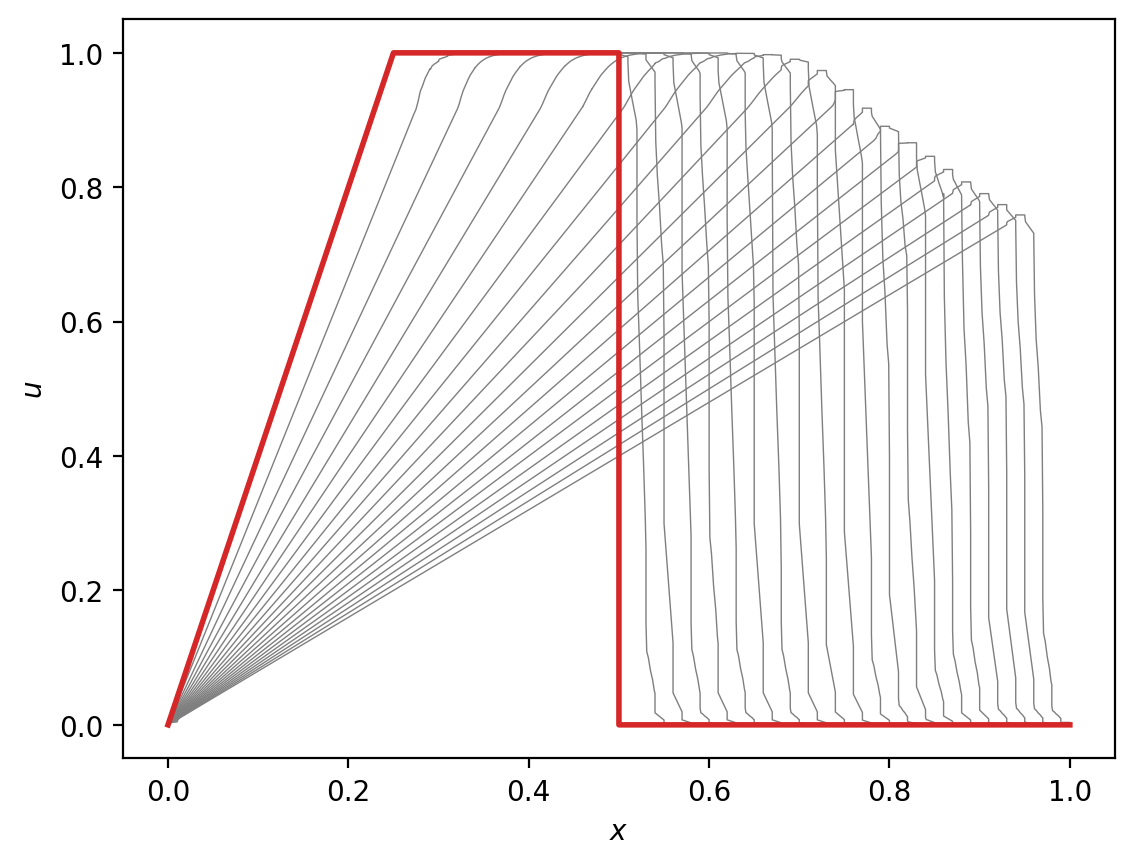

In [11]:
fig, ax = plt.subplots()
for i, uu in enumerate(uplot[1:]):
    ax.plot(xx.ravel(order='F'), uu.ravel(order='F'), '-',
            color='tab:gray', lw=0.5)

uu = uplot[0]
ax.plot(xx.ravel(order='F'), uu.ravel(order='F'), '-',
        color='tab:red', lw=2.0)

ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
plt.show()

In [ ]:
def mytest(test):
    @functools.wraps(test)
    def wrapper():
        test()
        print(f'{test.__name__}: pass')
    return wrapper

@mytest
def test1():
    mesh = Mesh(p=10, nel=5)
    u = np.sin(np.pi*mesh.qx/2)
    du = (1/2)*np.pi*np.cos(np.pi*mesh.qx/2)
    np.testing.assert_array_almost_equal(du, mesh.D @ u, 5)

test1()

Steps:
1. Fill in the rest of the code for `L(u)`
2. Are there additional unit tests?
3. Add the limiter in the time stepper
4. Is the limiter activating?  If so, where?
5. Try different values of thresholds

In [ ]:
a = np.array([[2, 1], [1, 2]])
a @ a